# __Unit Roots, Cointegration, and Error-Correction Models__

<br>

Finance 5330: Financial Econometrics <br>
Tyler J. Brough <br>
Last Update: April 15, 2021 <br>
<br>

In [1]:
using StatsKit
using StatsPlots

## Unit Roots and Stationarity 

A simple starting model for efficient log-prices of assets is the ___Random Walk with Drift___ model:

<br>

$$
y_{t} = \mu + y_{t-1} + \epsilon_{t}, \quad \quad \epsilon_{t} \sim N(0, \sigma_{\epsilon}^{2})
$$

<br>

with something like $y_{t} = \ln{(p_{t})}$ with $p_{t}$ a transaction price observed in some market. The expected value of this process is: 

<br>

$$
E(y_{t}) = \mu + y_{t-1}
$$

<br>

To get the variance it is helpful to solve recursively as follows, assuming $y_{0} = 0$ for simplicity:

<br>

$$
y_{t} = t \mu + \sum\limits_{i=0}^{t} \epsilon_{t-i}
$$

<br>

We can now state the variance of the process as:

<br>

$$
Var(y_{t}) = \sum\limits_{i=0}^{t} Var(\epsilon_{t-i}) = Var(\epsilon_{t}) + Var(\epsilon_{t-1}) + \cdots + Var(\epsilon_{0}) = t \sigma_{\epsilon}^{2}
$$

<br>

From this it is easy to see that this is an explosive process as the variance is proportional to time. This translates to the value of the process at any time $t$ being unpredictable based on the information known up to that time ($I_{t-1}$). This is a good starting place for a model of informationally efficient prices as the definition of such is one that incorporates all available information up to that point in time. 

<br>

__NB:__ Samuelson's paper: [Proof That Properly Anticipated Prices Fluctuate Randomly](https://www.worldscientific.com/doi/abs/10.1142/9789814566926_0002)

<br>

We can simulate this process as follows (setting $\mu = 0$ for convenience):

<br>

In [4]:
y = cumsum(randn(52*5));

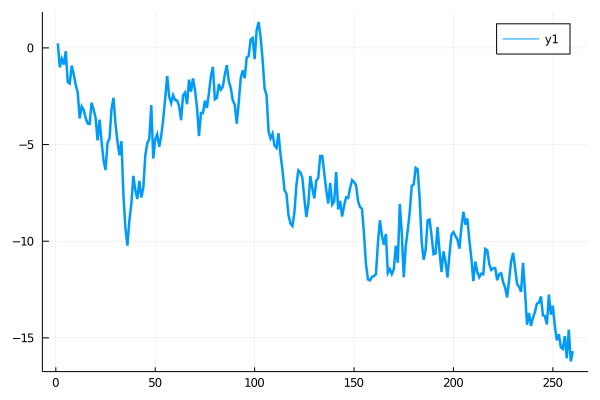

In [20]:
plot(y, lw=2.5)

### Weak Stationarity


<br>

In the time series literature a process is known as [weakly stationary](https://en.wikipedia.org/wiki/Stationary_process#Weak_or_wide-sense_stationarity) if the mean and autocovariance are not time varying. 

<br>

A few notes:

* Clearly the random walk process is __NOT__ weakly stationary.
* A weakly stationary time series process will exhibit mean reversion
* Mean reversion in a time series can be such that there is some predictibility in the process

<br>

It makes sense that informationally efficient prices should behave as a random walk model (with possible other extensions).


<br>
<br>

The random walk model is a special case of the AR(1) model ($y_{t}$ is now thought of as an arbitrary random variable):

<br>

$$
y_{t} = \phi y_{t-1} + \epsilon_{t}
$$

<br>

It won't be shown here, but a technical requirement for the AR(1) model to be weakly stationary is $|\phi| < 1$. For the random walk model $\phi = 1$, thus the alternative name ___unit root___.

<br>
<br>

### Some Notation

A random walk model is also known as a unit-root non-stationary process. In the literature this is often denoted as $y_{t} \sim I(1)$. We state this as: "_the process $y_{t}$ is_ ___integrated of order one___."

<br>
<br>

We can tranform and $I(1)$ process to a stationary process by ___first differencing___ the process like so:

<br>

$$
\begin{aligned}
y_{t} - y_{t-1} &= y_{t-1} - y_{t-1} + \epsilon_{t} \\
y_{t} - y_{t-1} &= \epsilon_{t} \\
\Delta y_{t}    &= \epsilon_{t} \\
r_{t}          &= \epsilon_{t}
\end{aligned}
$$

<br>
<br>

In this case we can denote that $\Delta y_{t}$ is now weakly stationary with the notation $\Delta y_{t} \sim I(0)$, i.e. "$\Delta y_{t}$ _is_ ___integrated of order zero.___"

## Spurious Regression

<br>

It is important to understand the properties of unit root processes, because they can be problematic to work with in applying econometrics to finance. 

<br>

For example, there is a well-known problem of ___spurious regression___ when one unit root process is regressed on an independent unit root process:

<br>

$$
y_{t} = \alpha + \beta x_{t} + u_{t}, \quad u_{t} \sim N(0, \sigma_{u}^{2})
$$

<br>

This regression is not valid because the homoscedasticity assumption of the error term is violated (recall that $Var(y_{t}) = t\sigma_{\epsilon}^{2}$)

<br>
<br>

This can be easily demonstrated by a simple Monte Carlo study as follows:

<br>

In [7]:
M = 10_000
N = 52 * 5
β̂ = zeros(M);
R² = zeros(M);

In [16]:
for i = 1:M
    y = cumsum(randn(N))
    x = cumsum(randn(N))
    data = DataFrame(Y=y,X=x);
    reg = lm(@formula(Y ~ X), data);
    β̂[i] = coef(reg)[2];
    R²[i] = r2(reg);
end

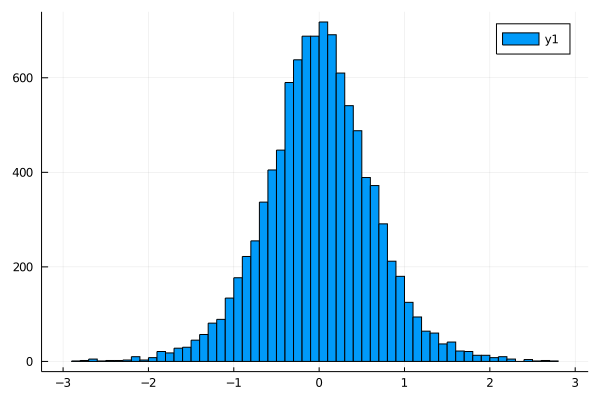

In [17]:
histogram(β̂)

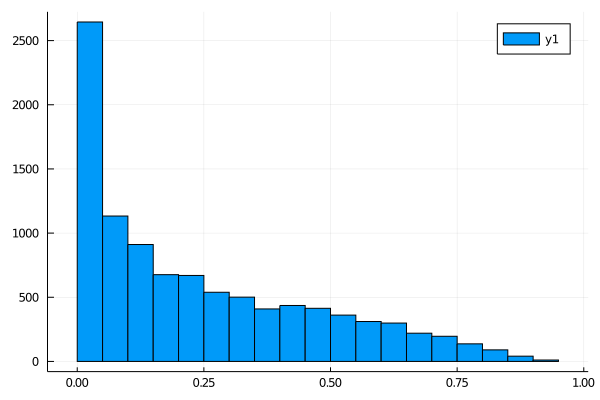

In [18]:
histogram(R²)

<br>

While the central tendency of sampling distribution appears to be zero, the distribution is extremely wide, so while we will fail to reject the null hypothesis on average we will fail to do so far too often. 

<br>

We can also see from histogram of the $R^{2}$ that there are some extremely high values even though we know that the processes are independent!

<br>

## The Dickey-Fuller Test for Unit Roots

<br>

We can test for unit roots in a time series process with the so-called ___Dickey-Fuller Test___, named for the statisticians who invented it. 

<br>

It would seem natural to test the following hypothesis: 

<br>

$$
\begin{aligned}
H_{0}: \phi = 1 \\
H_{a}: \phi \ne 1
\end{aligned}
$$

<br>

for the regression: $y_{t} = \phi y_{t-1} + \epsilon_{t}$, but because the model under the null hypothesis leads to spurious regression we cannot conduct this direct test. 

<br>

D-F had the bright idea to transform the model to render it amenable to such testing. We start by subtracting $y_{t-1}$ from both sides:

<br>

$$
\begin{aligned}
y_{t} - y_{t-1} &= \phi y_{t-1} - y_{t-1} + \epsilon_{t} \\
\Delta y_{t}    &= (\phi - 1) y_{t-1} + \epsilon_{t} \\
\Delta y_{t}    &= \theta y_{t-1} + \epsilon_{t}
\end{aligned}
$$

<br>

where $\theta = \phi - 1$. With this transformation we can now conduct the test:

<br>

$$
\begin{aligned}
H_{0}: \theta = 0 \\
H_{a}: \theta \ne 0
\end{aligned}
$$

<br>

Because $\Delta y_{t} \sim I(0)$ and when $\phi = 1$ it means that $\theta = 0$ this model is now valid under the null hypothesis. We can form the standard $t$-ratio as our test statistic, but D-F showed that the asymptotic sampling distribution of $t$ is no longer the Standard Normal distribution. Instead they provide critical values via a Monte Carlo method. 

<br>
<br>

### The Augmented Dickey-Fuller Test

<br>

D-F added one extension to the test to account for possible serial correlation in $\Delta y_{t}$. The model under the null hypothesis now becomes:

<br>

$$
\Delta y_{t} = \theta y_{t-1} + \sum\limits_{i=1}^{p} \gamma_{i} \Delta y_{t-i} + \epsilon_{t}
$$

<br>

This tends to make the test more robust to short-term serial correlations in the process.

<br>

We can use `HypothesisTests.jl` function `ADFTest` to conduct the ADF test as follows. 

See [HypothesisTests.jl documentation on ADFTest](https://juliastats.org/HypothesisTests.jl/latest/time_series/) for more details.

<br>

In [31]:
resids = GLM.residuals(reg);
ADFTest(residuals, none, 1)

LoadError: UndefVarError: none not defined

In [30]:
GLM.residuals(reg);

260-element Array{Float64,1}:
 11.89056066283035
 10.63285586662295
 11.009654971986924
 10.179188979631606
 11.191730587734332
  9.703125190695483
  9.372557137672903
  9.598150310037314
  8.67059190547175
  8.042848341465849
  7.479097054260839
  5.450522939935432
  6.072405103493966
  ⋮
 -5.985652818599107
 -4.9378188869523125
 -5.717938612720218
 -6.9336360246526105
 -6.537518049777349
 -6.601808816551792
 -6.983470103158341
 -6.291957543322919
 -7.369110438999071
 -6.389685095789472
 -8.406668080520198
 -8.068658438558716